In [1]:
import sys
import pandas as pd
import matplotlib
import numpy as np
import scipy as sp
import IPython
from IPython import display
import sklearn
import random
import time
import warnings
warnings.filterwarnings('ignore')
print('-'*25)

from sklearn import svm, tree, linear_model, neighbors, naive_bayes, ensemble, discriminant_analysis, gaussian_process

from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn import feature_selection
from sklearn import model_selection
from sklearn import metrics

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns
from pandas.tools.plotting import scatter_matrix

-------------------------


In [2]:
mpl.style.use('ggplot')
sns.set_style('white')
pylab.rcParams['figure.figsize'] = 12,8

## Read data

In [3]:
data_raw = pd.read_csv(r'C:\Users\pc\Desktop\Data Science Folder\Titanic Machine Learning From Disaster\train.csv')
data_val  = pd.read_csv(r'C:\Users\pc\Desktop\Data Science Folder\Titanic Machine Learning From Disaster\test.csv')

In [4]:
data1 = data_raw.copy(deep = True)
data_cleaner = [data1, data_val]

In [5]:
print('Train columns with null values:\n', data1.isnull().sum())
print("-"*10)

print('Test/Validation columns with null values:\n', data_val.isnull().sum())
print("-"*10)

Train columns with null values:
 PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64
----------
Test/Validation columns with null values:
 PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64
----------


## Fill missing values


In [6]:
for dataset in data_cleaner:    
    
    dataset['Age'].fillna(dataset['Age'].median(), inplace = True)

    dataset['Embarked'].fillna(dataset['Embarked'].mode()[0], inplace = True)

    dataset['Fare'].fillna(dataset['Fare'].median(), inplace = True)

## Drop unnecessary data

In [8]:
drop_column = ['PassengerId','Cabin', 'Ticket']
data1.drop(drop_column, axis=1, inplace = True)

In [7]:
print(data1.isnull().sum())
print("-"*10)
print(data_val.isnull().sum())

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         0
dtype: int64
----------
PassengerId      0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          327
Embarked         0
dtype: int64


## Adding new columns to data1 and data_val

In [9]:
for dataset in data_cleaner:    
    
    dataset['FamilySize'] = dataset ['SibSp'] + dataset['Parch'] + 1

    dataset['IsAlone'] = 1 #initialize to yes/1 is alone
   
    dataset['IsAlone'][dataset['FamilySize'] > 1] = 0

    dataset['Title'] = dataset['Name'].str.split(", ", expand=True)[1].str.split(".", expand=True)[0]

    dataset['FareBin'] = pd.qcut(dataset['Fare'], 4)

    dataset['AgeBin'] = pd.cut(dataset['Age'].astype(int), 5)


## Modify 'Title' column

In [10]:
print('******before******\n' , data1['Title'].value_counts(), '\n')

title_names = data1['Title'].value_counts() < 10 
data1['Title'] = data1['Title'].apply(lambda x: 'Misc' if title_names.loc[x] == True else x)

print('******after*******\n' , data1['Title'].value_counts())

******before******
 Mr              517
Miss            182
Mrs             125
Master           40
Dr                7
Rev               6
Major             2
Col               2
Mlle              2
Mme               1
Capt              1
Ms                1
Lady              1
the Countess      1
Don               1
Sir               1
Jonkheer          1
Name: Title, dtype: int64 

******after*******
 Mr        517
Miss      182
Mrs       125
Master     40
Misc       27
Name: Title, dtype: int64


## Introduction to LabelEncoder().fit_transform

In [11]:
print( LabelEncoder().fit_transform( data1['Embarked'] )[ range(0,20)] )

[2 0 2 2 2 1 2 2 2 0 2 2 2 2 2 2 1 2 2 0]



## Adding new columns to data1 and data_val

In [12]:
label = LabelEncoder()
for dataset in data_cleaner:    
    dataset['Sex_Code'] = label.fit_transform(dataset['Sex'])
    dataset['Embarked_Code'] = label.fit_transform(dataset['Embarked'])
    dataset['Title_Code'] = label.fit_transform(dataset['Title'])
    dataset['AgeBin_Code'] = label.fit_transform(dataset['AgeBin'])
    dataset['FareBin_Code'] = label.fit_transform(dataset['FareBin'])

## Lists containing column names


In [13]:
Target = ['Survived']

data1_x = ['Sex','Pclass', 'Embarked', 'Title','SibSp', 'Parch', 'Age', 'Fare', 'FamilySize', 'IsAlone']
data1_xy =  Target + data1_x

data1_x_calc = ['Sex_Code','Pclass', 'Embarked_Code', 'Title_Code','SibSp', 'Parch', 'Age', 'Fare'] #coded for algorithm calculation


data1_x_bin = ['Sex_Code','Pclass', 'Embarked_Code', 'Title_Code', 'FamilySize', 'AgeBin_Code', 'FareBin_Code']
data1_xy_bin = Target + data1_x_bin

data1_dummy = pd.get_dummies( data1[data1_x] )
data1_x_dummy = data1_dummy.columns.tolist()



In [14]:

#**** for learning ***** 
print( data1_dummy )
print ( type(data1_dummy.columns) )
L = list(data1_dummy.columns)
print(L)
print( data1['Sex_Code'])

     Pclass  SibSp  Parch   Age      Fare  FamilySize  IsAlone  Sex_female  \
0         3      1      0  22.0    7.2500           2        0           0   
1         1      1      0  38.0   71.2833           2        0           1   
2         3      0      0  26.0    7.9250           1        1           1   
3         1      1      0  35.0   53.1000           2        0           1   
4         3      0      0  35.0    8.0500           1        1           0   
5         3      0      0  28.0    8.4583           1        1           0   
6         1      0      0  54.0   51.8625           1        1           0   
7         3      3      1   2.0   21.0750           5        0           0   
8         3      0      2  27.0   11.1333           3        0           1   
9         2      1      0  14.0   30.0708           2        0           1   
10        3      1      1   4.0   16.7000           3        0           1   
11        1      0      0  58.0   26.5500           1        1  

In [15]:
data1_xy_dummy = Target + data1_x_dummy

print('Dummy X Y: ', data1_xy_dummy, '\n')


Dummy X Y:  ['Survived', 'Pclass', 'SibSp', 'Parch', 'Age', 'Fare', 'FamilySize', 'IsAlone', 'Sex_female', 'Sex_male', 'Embarked_C', 'Embarked_Q', 'Embarked_S', 'Title_Master', 'Title_Misc', 'Title_Miss', 'Title_Mr', 'Title_Mrs'] 



## Checking the clean data

In [21]:
print('Train columns with null values: \n', data1.isnull().sum())
print("-"*10)
print (data1.info())
print("-"*10)

print('Test/Validation columns with null values: \n', data_val.isnull().sum())
print("-"*10)
print (data_val.info())
print("-"*10)

Train columns with null values: 
 Survived         0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Fare             0
Embarked         0
FamilySize       0
IsAlone          0
Title            0
FareBin          0
AgeBin           0
Sex_Code         0
Embarked_Code    0
Title_Code       0
AgeBin_Code      0
FareBin_Code     0
dtype: int64
----------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 19 columns):
Survived         891 non-null int64
Pclass           891 non-null int64
Name             891 non-null object
Sex              891 non-null object
Age              891 non-null float64
SibSp            891 non-null int64
Parch            891 non-null int64
Fare             891 non-null float64
Embarked         891 non-null object
FamilySize       891 non-null int64
IsAlone          891 non-null int64
Title            891 non-null object
FareBin          891 non-null catego

In [18]:
#******** for learning *********
print( type(data1[data1_x_calc]), '   ' , type(data1[Target]) )

<class 'pandas.core.frame.DataFrame'>     <class 'pandas.core.frame.DataFrame'>


In [16]:

train1_x, test1_x, train1_y, test1_y = model_selection.train_test_split(data1[data1_x_calc], data1[Target], random_state = 0)
train1_x_bin, test1_x_bin, train1_y_bin, test1_y_bin = model_selection.train_test_split(data1[data1_x_bin], data1[Target] , random_state = 0)
train1_x_dummy, test1_x_dummy, train1_y_dummy, test1_y_dummy = model_selection.train_test_split(data1_dummy[data1_x_dummy], data1[Target], random_state = 0)

## Veryfying the shape of train1_x & test1_x

In [19]:
print("Data1 Shape: {}".format(data1.shape))
print("Train1 Shape: {}".format(train1_x.shape))
print("Test1 Shape: {}".format(test1_x.shape))

Data1 Shape: (891, 19)
Train1 Shape: (668, 8)
Test1 Shape: (223, 8)


## Perform Exploratory Analysis with Statistics

In [22]:
for x in data1_x:
    if data1[x].dtype != 'float64' :
        print('Survival Correlation by:', x)
        print( (data1[[x, Target[0]]].groupby( x, as_index = False )).mean() )
        #print('-'*10, '\n')


print( pd.crosstab(data1['Title'], data1[ 'Survived' ]  ) )


Survival Correlation by: Sex
      Sex  Survived
0  female  0.742038
1    male  0.188908
Survival Correlation by: Pclass
   Pclass  Survived
0       1  0.629630
1       2  0.472826
2       3  0.242363
Survival Correlation by: Embarked
  Embarked  Survived
0        C  0.553571
1        Q  0.389610
2        S  0.339009
Survival Correlation by: Title
    Title  Survived
0  Master  0.575000
1    Misc  0.444444
2    Miss  0.697802
3      Mr  0.156673
4     Mrs  0.792000
Survival Correlation by: SibSp
   SibSp  Survived
0      0  0.345395
1      1  0.535885
2      2  0.464286
3      3  0.250000
4      4  0.166667
5      5  0.000000
6      8  0.000000
Survival Correlation by: Parch
   Parch  Survived
0      0  0.343658
1      1  0.550847
2      2  0.500000
3      3  0.600000
4      4  0.000000
5      5  0.200000
6      6  0.000000
Survival Correlation by: FamilySize
   FamilySize  Survived
0           1  0.303538
1           2  0.552795
2           3  0.578431
3           4  0.724138
4       

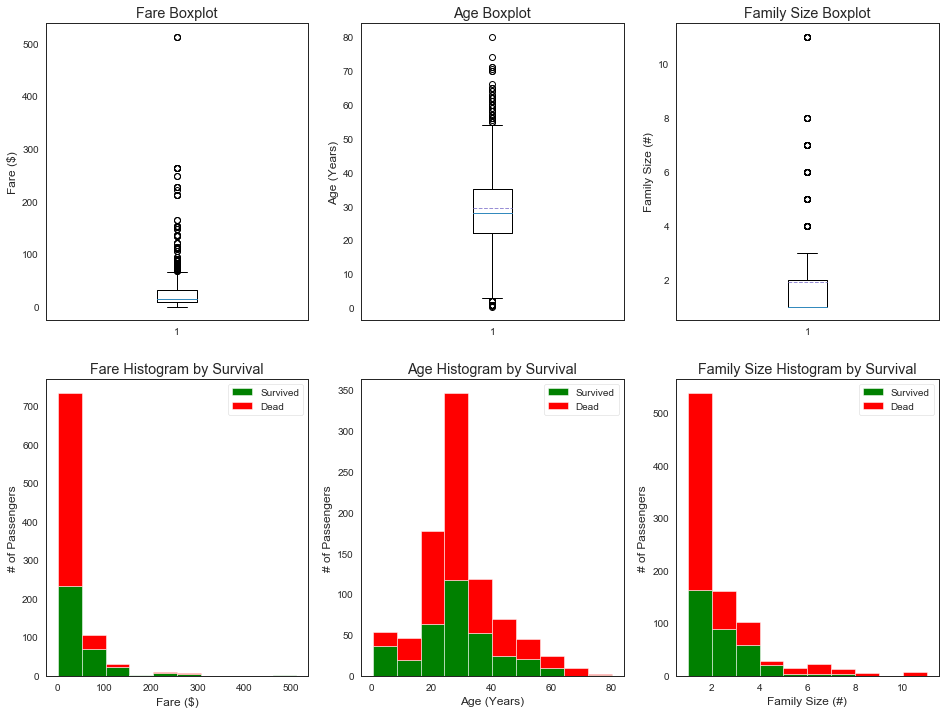

In [17]:
plt.figure(figsize=[16,12])

plt.subplot(231)
plt.boxplot(x=data1['Fare'])
plt.title('Fare Boxplot')
plt.ylabel('Fare ($)')

plt.subplot(232)
plt.boxplot(data1['Age'], showmeans = True, meanline = True)
plt.title('Age Boxplot')
plt.ylabel('Age (Years)')

plt.subplot(233)
plt.boxplot(data1['FamilySize'], showmeans = True, meanline = True)
plt.title('Family Size Boxplot')
plt.ylabel('Family Size (#)')

plt.subplot(234)
plt.hist(x = [data1[data1['Survived']==1]['Fare'], data1[data1['Survived']==0]['Fare']] , stacked=True, color = ['g', 'r'], label = ['Survived','Dead'])
plt.title('Fare Histogram by Survival')
plt.xlabel('Fare ($)')
plt.ylabel('# of Passengers')
plt.legend()

plt.subplot(235)
plt.hist(x = [data1[data1['Survived']==1]['Age'], data1[data1['Survived']==0]['Age']], 
         stacked=True, color = ['g','r'],label = ['Survived','Dead'])
plt.title('Age Histogram by Survival')
plt.xlabel('Age (Years)')
plt.ylabel('# of Passengers')
plt.legend()

plt.subplot(236)
plt.hist(x = [data1[data1['Survived']==1]['FamilySize'], data1[data1['Survived']==0]['FamilySize']], stacked=True, color = ['g','r'],label = ['Survived','Dead'])
plt.title('Family Size Histogram by Survival')
plt.xlabel('Family Size (#)')
plt.ylabel('# of Passengers')
plt.legend()

plt.show()


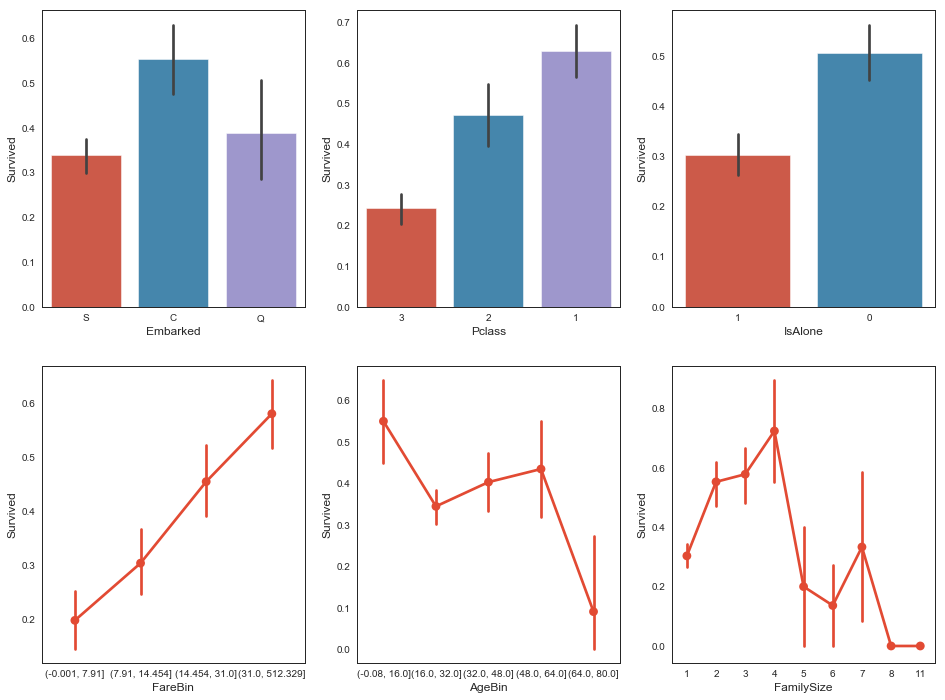

In [38]:
plt.figure(figsize=[16, 12])

plt.subplot(231)
sns.barplot(x = 'Embarked', y = 'Survived', data=data1)
plt.subplot(232)
sns.barplot(x = 'Pclass', y = 'Survived', order=[3,2,1], data=data1 );
plt.subplot(233)
sns.barplot(x = 'IsAlone', y = 'Survived', order=[1,0], data=data1 );


plt.subplot(234)
sns.pointplot(x = 'FareBin', y = 'Survived',  data=data1 );
plt.subplot(235)
sns.pointplot(x = 'AgeBin', y = 'Survived',  data=data1 );
plt.subplot(236)
sns.pointplot(x = 'FamilySize', y = 'Survived', data=data1 );
